In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
np.random.seed(10)

# GETTING THE DATASET
Here I download the dataset (3/4 Mb, but pandas is a bit slow to download it), delete the rows with missing values and replace the targets with a 0 and 1 instead of '<=50K', '>50K'

In [3]:
DATASET_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
columns = ['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-num', 'Marital-status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital-gain', 'Capital-loss', 'Hours-per-week', 'Native-country', 'Target']
df = pd.read_csv(DATASET_URL, names=columns, na_values=['?', ' ?', '? '])

In [4]:
# strip the strings
df_str = df.select_dtypes(['object'])
df[df_str.columns] = df_str.apply(lambda x: x.str.strip())
# remove missing values and duplicates
df = df.dropna()
df = df.drop_duplicates()
# map the target into {0,1}
map_targ = {
        '<=50K': 0,
        '>50K': 1
}
df['Target'] = df.iloc[:, -1].map(map_targ)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30139 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             30139 non-null  int64 
 1   Workclass       30139 non-null  object
 2   Fnlwgt          30139 non-null  int64 
 3   Education       30139 non-null  object
 4   Education-num   30139 non-null  int64 
 5   Marital-status  30139 non-null  object
 6   Occupation      30139 non-null  object
 7   Relationship    30139 non-null  object
 8   Race            30139 non-null  object
 9   Sex             30139 non-null  object
 10  Capital-gain    30139 non-null  int64 
 11  Capital-loss    30139 non-null  int64 
 12  Hours-per-week  30139 non-null  int64 
 13  Native-country  30139 non-null  object
 14  Target          30139 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [6]:
df['Target'].value_counts()

0    22633
1     7506
Name: Target, dtype: int64

In [7]:
# percentage of zeroes and ones
ZEROS_PERC, ONES_PERC = df['Target'].value_counts(normalize=True)

In [8]:
df.head(3)

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0


# Features preparation

Extract the numerical features and scale them

In [9]:
from sklearn.preprocessing import StandardScaler, Normalizer

In [10]:
NUMERICAL_FEATURES = ['Age', 'Fnlwgt', 'Education-num', 'Capital-gain', 'Capital-loss']

df_numerical = df[NUMERICAL_FEATURES + ['Target']].copy()

# Scale the numerical features
scaler = StandardScaler()
df_numerical[NUMERICAL_FEATURES] = scaler.fit_transform(df_numerical[NUMERICAL_FEATURES])

In [11]:
df_numerical

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Target
0,0.042516,-1.062676,1.128996,0.145925,-0.218673,0
1,0.880215,-1.007829,1.128996,-0.147502,-0.218673,0
2,-0.033639,0.244669,-0.440434,-0.147502,-0.218673,0
3,1.108678,0.425206,-1.225149,-0.147502,-0.218673,0
4,-0.795183,1.406572,1.128996,-0.147502,-0.218673,0
...,...,...,...,...,...,...
32556,-0.871338,0.638926,0.736639,-0.147502,-0.218673,0
32557,0.118670,-0.335246,-0.440434,-0.147502,-0.218673,1
32558,1.489450,-0.358567,-0.440434,-0.147502,-0.218673,0
32559,-1.252110,0.110688,-0.440434,-0.147502,-0.218673,0


# Clustering

Imports and utility functions

In [12]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from kneed import KneeLocator

In [13]:
CLUSTERS = [*range(2, 12)]

In [14]:
def print_metrics(X, kmeans):
    """print the metrics of the kmeans model.
    Parameters
    ----------
        X - normalized dataset
        kmeans - model.
    Prints
    ------
        K
        SSE
        Silhouette score
        Separation
    
    """
    print(f'K={len(kmeans.cluster_centers_)}')
    print('\tSSE:\t\t{}'.format(kmeans.inertia_))
    print('\tSilhouette:\t\t{}'.format(metrics.silhouette_score(X, kmeans.labels_)))
    print('\tDaviesBouldin score:\t\t{}'.format(metrics.davies_bouldin_score(X, kmeans.labels_)))

def run_kmeans(X, range_nclusters=CLUSTERS):
    '''runs kmeans for different values of k'''
    inertia, models = [], []
    for k in range_nclusters:
        k_means = KMeans(init='k-means++', n_clusters= k, n_init=20, random_state=123)
        model = k_means.fit(X) #returns fitted estimator
        models.append(model)
        inertia.append(k_means.inertia_)
    return inertia, models

def plot_silouette(data, models):
    """
    models - list of already fit kmeans models
    """
    fig, axs = plt.subplots(ncols=len(models), figsize=(15,5), sharex=True, sharey=True)
    for i,model in enumerate(models):
        nclusters = model.n_clusters
        axs[i].set_xlim([-0.1, 1])
        axs[i].set_ylim([0, len(data) + (nclusters + 1) * 10])
        axs[i].set_title(f"$K={nclusters}$")
        
        clusters = model.predict(data)
        silhouette_avg = silhouette_score(data, clusters)
        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, clusters)
        
        y_lower = 10
        for j in range(nclusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[clusters == j]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(j) / nclusters)
            axs[i].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            axs[i].text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        
        # The vertical line for average silhouette score of all the values
        axs[i].axvline(x=silhouette_avg, color="red", linestyle="--")

        axs[i].set_yticks([])  # Clear the yaxis labels / ticks
        axs[i].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        
    plt.tight_layout()

## Class 0
Compute the clusters for class $0$

In [15]:
zeroes = df_numerical[df_numerical['Target'] == 0].copy()

In [16]:
wcss_0, models_0 = run_kmeans(zeroes[NUMERICAL_FEATURES])

In [17]:
for m in models_0:
    print_metrics(zeroes[NUMERICAL_FEATURES], m)

K=2
	SSE:		63831.00674116211
	Silhouette:		0.2552998888638537
	DaviesBouldin score:		1.581301395476283
K=3
	SSE:		51503.0174727532
	Silhouette:		0.27813943678632086
	DaviesBouldin score:		1.1913434368355498
K=4
	SSE:		40636.09948004912
	Silhouette:		0.2843852517397693
	DaviesBouldin score:		1.083047950117436
K=5
	SSE:		33723.290347028604
	Silhouette:		0.29922619998416083
	DaviesBouldin score:		0.9977057657651812
K=6
	SSE:		29483.557526698864
	Silhouette:		0.3070600574999428
	DaviesBouldin score:		0.9979324332981961
K=7
	SSE:		26760.339259532586
	Silhouette:		0.270694082019993
	DaviesBouldin score:		1.047926295733393
K=8
	SSE:		24715.332045885636
	Silhouette:		0.256985518762944
	DaviesBouldin score:		1.0559173553310746
K=9
	SSE:		22903.12106860362
	Silhouette:		0.26322841507445494
	DaviesBouldin score:		1.0261740095776104
K=10
	SSE:		21374.70532036135
	Silhouette:		0.2696351020444503
	DaviesBouldin score:		1.0120815164789208
K=11
	SSE:		19928.19568087851
	Silhouette:		0.2784019675645391

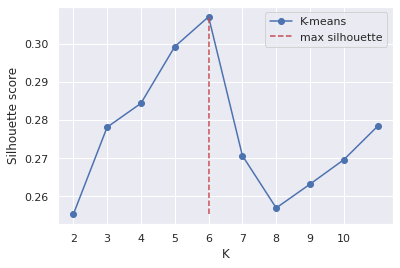

In [18]:
sil_score_0 = []
for m in models_0:
    sil_score_0.append(silhouette_score(zeroes[NUMERICAL_FEATURES], m.labels_))
    
plt.plot(CLUSTERS, sil_score_0, 'bo-', label="K-means")
plt.vlines(np.argmax(sil_score_0) + 2, min(sil_score_0), max(sil_score_0), 'r', '--', label="max silhouette")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.xticks(range(2, 11))
plt.ylabel("Silhouette score")
plt.legend()
plt.show()

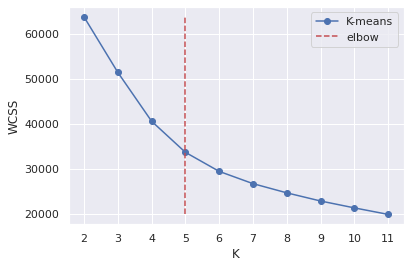

In [19]:
kl = KneeLocator(CLUSTERS, wcss_0, curve="convex", direction="decreasing")
plt.plot(CLUSTERS, wcss_0, 'o-', label="K-means")
plt.vlines(kl.elbow, min(wcss_0), max(wcss_0), 'r', '--', label="elbow")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.ylabel("WCSS")
plt.legend()
plt.show()

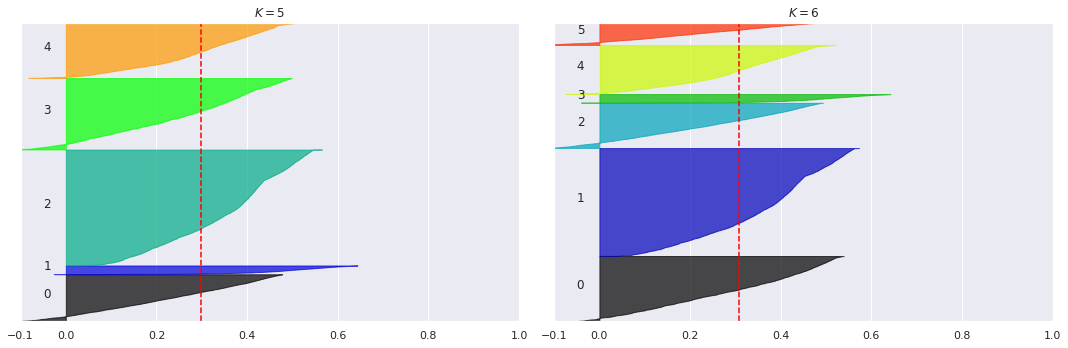

In [20]:
plot_silouette(zeroes[NUMERICAL_FEATURES], models_0[3:5])

Pick $k = 5$

In [21]:
kmeans_0 = models_0[3]
print(kmeans_0)

KMeans(n_clusters=5, n_init=20, random_state=123)


In [22]:
clusters_0 = kmeans_0.predict(zeroes[NUMERICAL_FEATURES])

zeroes['Cluster'] = clusters_0

zeroes

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Target,Cluster
0,0.042516,-1.062676,1.128996,0.145925,-0.218673,0,4
1,0.880215,-1.007829,1.128996,-0.147502,-0.218673,0,4
2,-0.033639,0.244669,-0.440434,-0.147502,-0.218673,0,2
3,1.108678,0.425206,-1.225149,-0.147502,-0.218673,0,3
4,-0.795183,1.406572,1.128996,-0.147502,-0.218673,0,0
...,...,...,...,...,...,...,...
32553,-0.490566,-0.697134,1.521353,-0.147502,-0.218673,0,4
32555,-1.252110,1.139131,-0.048076,-0.147502,-0.218673,0,0
32556,-0.871338,0.638926,0.736639,-0.147502,-0.218673,0,4
32558,1.489450,-0.358567,-0.440434,-0.147502,-0.218673,0,3


In [48]:
zeroes['Cluster'].value_counts(normalize=True)

2    0.388945
3    0.239783
4    0.184598
0    0.157602
1    0.029073
Name: Cluster, dtype: float64

## Class 1
Compute the clusters for class $1$

In [24]:
ones = df_numerical[df_numerical['Target'] == 1].copy()

In [25]:
wcss_1, models_1 = run_kmeans(ones[NUMERICAL_FEATURES])

In [26]:
for m in models_1:
    print_metrics(ones[NUMERICAL_FEATURES], m)

K=2
	SSE:		37150.38774810925
	Silhouette:		0.7969001241835686
	DaviesBouldin score:		0.2560647192018851
K=3
	SSE:		21254.271745611124
	Silhouette:		0.6033587746319867
	DaviesBouldin score:		0.4941953568760528
K=4
	SSE:		16816.13934462906
	Silhouette:		0.30347247765596697
	DaviesBouldin score:		0.9936463936829607
K=5
	SSE:		13789.572972048065
	Silhouette:		0.3178756875711479
	DaviesBouldin score:		0.9403264767486696
K=6
	SSE:		12180.671719785285
	Silhouette:		0.32950109162196806
	DaviesBouldin score:		0.9228915021564218
K=7
	SSE:		11035.897887392823
	Silhouette:		0.30585771902355596
	DaviesBouldin score:		0.9676521730211665
K=8
	SSE:		10129.200272678123
	Silhouette:		0.2864427613300817
	DaviesBouldin score:		1.0182902977182713
K=9
	SSE:		9518.804678173121
	Silhouette:		0.29312906896165103
	DaviesBouldin score:		1.0826880661658844
K=10
	SSE:		8984.522411893195
	Silhouette:		0.26285808597042515
	DaviesBouldin score:		1.205239616582261
K=11
	SSE:		8475.424912019114
	Silhouette:		0.26711338

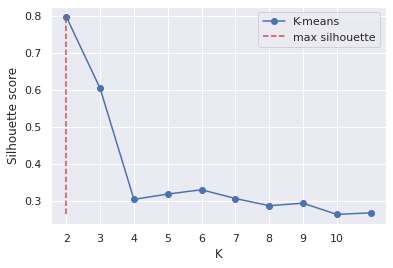

In [27]:
sil_score_1 = []
for m in models_1:
    sil_score_1.append(silhouette_score(ones[NUMERICAL_FEATURES], m.labels_))
    
plt.plot(CLUSTERS, sil_score_1, 'bo-', label="K-means")
plt.vlines(np.argmax(sil_score_1) + 2, min(sil_score_1), max(sil_score_1), 'r', '--', label="max silhouette")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.xticks(range(2, 11))
plt.ylabel("Silhouette score")
plt.legend()
plt.show()

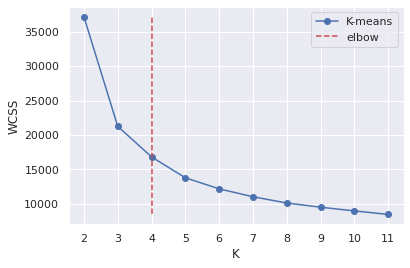

In [28]:
kl = KneeLocator(CLUSTERS, wcss_1, curve="convex", direction="decreasing")
plt.plot(CLUSTERS, wcss_1, 'o-', label="K-means")
plt.vlines(kl.elbow, min(wcss_1), max(wcss_1), 'r', '--', label="elbow")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.ylabel("WCSS")
plt.legend()
plt.show()

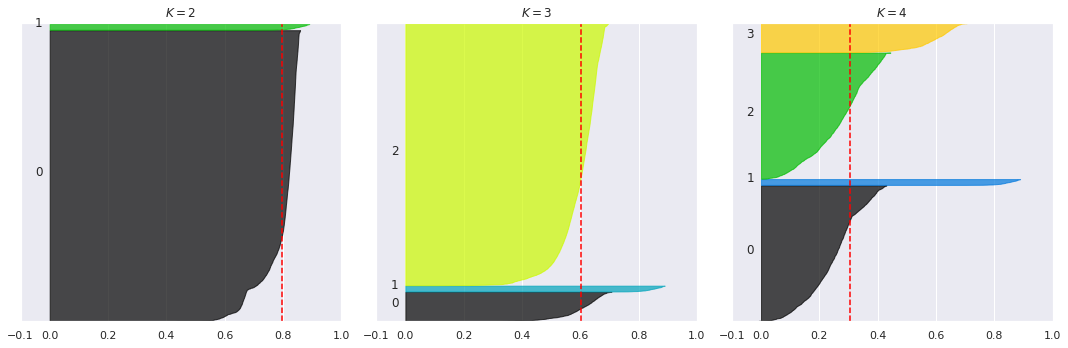

In [29]:
plot_silouette(ones[NUMERICAL_FEATURES], models_1[:3])

Pick $k=4$

In [30]:
kmeans_1 = models_1[2]
print(kmeans_1)

KMeans(n_clusters=4, n_init=20, random_state=123)


In [31]:
clusters_1 = kmeans_1.predict(ones[NUMERICAL_FEATURES])

ones['Cluster'] = clusters_1

ones

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Target,Cluster
7,1.032523,0.187844,-0.440434,-0.147502,-0.218673,1,2
8,-0.566720,-1.363035,1.521353,1.753432,-0.218673,1,0
9,0.270979,-0.287213,1.128996,0.551379,-0.218673,1,0
10,-0.109793,0.858146,-0.048076,-0.147502,-0.218673,1,2
11,-0.642875,-0.459014,1.128996,-0.147502,-0.218673,1,0
...,...,...,...,...,...,...,...
32538,-0.033639,-0.479051,1.128996,1.879765,-0.218673,1,0
32545,0.042516,-0.741041,0.736639,-0.147502,-0.218673,1,0
32554,1.108678,1.249989,1.521353,-0.147502,-0.218673,1,0
32557,0.118670,-0.335246,-0.440434,-0.147502,-0.218673,1,2


In [32]:
ones['Cluster'].value_counts()

0    3432
2    3191
3     735
1     148
Name: Cluster, dtype: int64

In [47]:
from sklearn.model_selection import train_test_split

In [ ]:
aaa = train_test_split(

# Sampling

# Test, Training, Validation splitting

In [62]:
train_test_0, validation_0 = train_test_split(zeroes, train_size=0.8, stratify=zeroes['Cluster'])
train_0, test_0 = train_test_split(train_test_0, train_size=0.7, stratify=train_test_0['Cluster'])

train_test_1, validation_1 = train_test_split(ones, train_size=0.8, stratify=ones['Cluster'])
train_1, test_1 = train_test_split(train_test_1, train_size=0.7, stratify=train_test_1['Cluster'])

In [80]:
# the validation set is (roughly) the 20% of the total dataset
assert abs(len(validation_0) + len(validation_1) - 0.2*len(df)) < 5
# the train set is (roughly) the 80% of the remaining dataset
assert abs(len(train_1) + len(train_0)-0.7*(len(df) - 0.2 * len(df))) < 5

In [82]:
# check that each set has roughly the same distribution of clusters
print(zeroes['Cluster'].value_counts(normalize=True))
print(train_test_0['Cluster'].value_counts(normalize=True))
print(train_0['Cluster'].value_counts(normalize=True))
print(test_0['Cluster'].value_counts(normalize=True))
print(validation_0['Cluster'].value_counts(normalize=True))

2    0.388945
3    0.239783
4    0.184598
0    0.157602
1    0.029073
Name: Cluster, dtype: float64
2    0.388932
3    0.239810
4    0.184580
0    0.157627
1    0.029051
Name: Cluster, dtype: float64
2    0.388906
3    0.239782
4    0.184630
0    0.157646
1    0.029036
Name: Cluster, dtype: float64
2    0.388991
3    0.239875
4    0.184462
0    0.157585
1    0.029087
Name: Cluster, dtype: float64
2    0.388999
3    0.239673
4    0.184670
0    0.157499
1    0.029158
Name: Cluster, dtype: float64


In [83]:
# check that each set has roughly the same distribution of clusters
print(ones['Cluster'].value_counts(normalize=True))
print(train_test_1['Cluster'].value_counts(normalize=True))
print(train_1['Cluster'].value_counts(normalize=True))
print(test_1['Cluster'].value_counts(normalize=True))
print(validation_1['Cluster'].value_counts(normalize=True))

0    0.457234
2    0.425127
3    0.097922
1    0.019718
Name: Cluster, dtype: float64
0    0.457195
2    0.425217
3    0.097935
1    0.019654
Name: Cluster, dtype: float64
0    0.457163
2    0.425274
3    0.097811
1    0.019752
Name: Cluster, dtype: float64
0    0.457270
2    0.425083
3    0.098224
1    0.019423
Name: Cluster, dtype: float64
0    0.457390
2    0.424767
3    0.097870
1    0.019973
Name: Cluster, dtype: float64


In [95]:
train_0.index

Int64Index([ 5046, 17919, 23876,  3720,  7957, 23258, 11438, 22938, 17273,
             1586,
            ...
            30643, 29556, 14216, 21617, 12421, 11167, 21246, 10304,  3514,
            30333],
           dtype='int64', length=12674)

In [96]:
train_0

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Target,Cluster
5046,0.575597,-1.246195,-0.440434,-0.147502,-0.218673,0,3
17919,0.118670,-0.019810,1.128996,-0.147502,-0.218673,0,4
23876,1.184832,1.348213,-0.832791,-0.147502,-0.218673,0,3
3720,0.575597,-1.258357,-0.440434,-0.147502,-0.218673,0,3
7957,-0.947492,0.213038,-2.402221,-0.147502,-0.218673,0,2
...,...,...,...,...,...,...,...
11167,-1.099801,-0.690869,0.344281,-0.147502,-0.218673,0,2
21246,1.717914,-0.888404,-2.009864,-0.147502,-0.218673,0,3
10304,-0.642875,0.158219,1.128996,-0.147502,-0.218673,0,4
3514,0.042516,-1.077072,-0.440434,-0.147502,-0.218673,0,2


# Random Forest Creation

In [116]:
df

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [126]:
t0 = df.loc[train_0.index]
t1 = df.loc[train_1.index]

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target
5046,46,Private,58126,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
17919,40,Private,187702,Bachelors,13,Never-married,Tech-support,Not-in-family,White,Male,0,0,40,United-States,0
23876,54,Federal-gov,332243,12th,8,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,0
3720,46,Private,56841,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
7957,26,Private,212304,7th-8th,4,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,48,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11167,24,Private,116800,Assoc-voc,11,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,35,United-States,0
21246,61,Private,95929,9th,5,Divorced,Other-service,Not-in-family,White,Male,0,0,40,United-States,0
10304,30,Private,206512,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,44,United-States,0
3514,39,Private,75995,HS-grad,9,Divorced,Exec-managerial,Unmarried,White,Female,0,0,45,United-States,0


In [127]:
df

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [128]:
df.loc[0]

Age                          39
Workclass             State-gov
Fnlwgt                    77516
Education             Bachelors
Education-num                13
Marital-status    Never-married
Occupation         Adm-clerical
Relationship      Not-in-family
Race                      White
Sex                        Male
Capital-gain               2174
Capital-loss                  0
Hours-per-week               40
Native-country    United-States
Target                        0
Name: 0, dtype: object